# Modling by ARIMA 2 

data: https://www.kaggle.com/datasets/allanjackson/rossmann


check also the walmart dataset 

In [ ]:
! pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 7.0 MB/s 
     |████████████████████████████████| 9.8 MB 26.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
! pip install statsmodels 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install pystan==2.19.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 3.3 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 45 kB 1.8 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6641006 sha256=94965acbefff9a6cb43bf377fda63b617f9e7b013d2f326cd5a4b4a3049a17cf
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [ ]:
import pandas as pd 
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt 


import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from matplotlib.cbook import boxplot_stats

import time 
import datetime
from datetime import timedelta
from datetime import datetime

import statsmodels.tsa.api as smt
import statsmodels.tsa as tsa
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet import Prophet

from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

import pmdarima as pm
from pmdarima.arima import auto_arima



In [ ]:
train_data_source ='https://raw.githubusercontent.com/AshrafHabromman/Rossmann_Sales_Forecasting/main/data/train.csv'
train_data_l = r'data\train.csv'
df_train = pd.read_csv(train_data_source, index_col = ['Store', 'Date'], parse_dates = True,)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_train.head() 

,,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Store,Date,,,,,,,
1,2015-07-31,5,5263,555,1,1,0,1
2,2015-07-31,5,6064,625,1,1,0,1
3,2015-07-31,5,8314,821,1,1,0,1
4,2015-07-31,5,13995,1498,1,1,0,1
5,2015-07-31,5,4822,559,1,1,0,1


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1017209 entries, (1, Timestamp('2015-07-31 00:00:00')) to (1115, Timestamp('2013-01-01 00:00:00'))
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   DayOfWeek      1017209 non-null  int64 
 1   Sales          1017209 non-null  int64 
 2   Customers      1017209 non-null  int64 
 3   Open           1017209 non-null  int64 
 4   Promo          1017209 non-null  int64 
 5   StateHoliday   1017209 non-null  object
 6   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 58.3+ MB


Add DayOfWeek feature to df_train 

In [ ]:
df_train['DayOfWeek'] = df_train.index.get_level_values('Date').dayofweek
df_train['Week'] = df_train.index.get_level_values('Date').week 
df_train['month'] = df_train.index.get_level_values('Date').month
df_train['year'] = df_train.index.get_level_values('Date').year
df_train['dayofyear'] = df_train.index.get_level_values('Date').dayofyear

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


In [ ]:
store_data_source = 'https://raw.githubusercontent.com/AshrafHabromman/Rossmann_Sales_Forecasting/main/data/store.csv'
store_data_l = r'data\store.csv'
df_store = pd.read_csv(store_data_source)
df_store.head() 

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [ ]:
df_store.isnull().sum() 


Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [ ]:
df_train.reset_index('Date', inplace=True)
train_store = pd.merge(df_train, df_store, how='inner', on='Store')
train_store.head()

,Store,Date,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Week,...,dayofyear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,2015-07-31,4,5263,555,1,1,0,1,31,...,212,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,2015-07-30,3,5020,546,1,1,0,1,31,...,211,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,2015-07-29,2,4782,523,1,1,0,1,31,...,210,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2015-07-28,1,5011,560,1,1,0,1,31,...,209,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,2015-07-27,0,6102,612,1,1,0,1,31,...,208,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [ ]:
df_train.set_index('Date',append=True, inplace=True)

In [ ]:
# ind = pd.Series(1, index = df_train.loc[1,:].index).asfreq('D')
# indNa = ind[ind.isnull()].index
# len(indNa)

stores = df_train.groupby('Store')
stores_have_miss= {}
for store_num, store in stores:
    
    index = pd.Series(1, index = df_train.loc[store_num,:].index).asfreq('D')
    index_miss = index[index.isnull()].index
    first_miss = True
    if len(index_miss) != 0: 
        if first_miss: 
            prev_index_miss = index_miss
            total_index = index_miss
            first_miss = False
        new_index_date = total_index.difference(index_miss)
        total_index.append(new_index_date)
        total_index.sort_values()
        prev_index_miss = index_miss
        stores_have_miss[store_num] = len(index_miss)
#         stores_have_nan['num_missing'] = len(indNa)
        
        
stores_have_miss

{13: 184,
 20: 184,
 22: 184,
 32: 184,
 36: 184,
 41: 184,
 46: 184,
 51: 184,
 52: 184,
 58: 184,
 72: 184,
 76: 184,
 81: 184,
 89: 184,
 99: 184,
 100: 184,
 108: 184,
 113: 184,
 115: 184,
 127: 184,
 129: 184,
 132: 184,
 136: 184,
 137: 184,
 139: 184,
 144: 184,
 145: 184,
 149: 184,
 155: 184,
 159: 184,
 164: 184,
 165: 184,
 172: 184,
 174: 184,
 181: 184,
 183: 184,
 186: 184,
 190: 184,
 191: 184,
 192: 184,
 204: 184,
 215: 184,
 218: 184,
 231: 184,
 243: 184,
 258: 184,
 263: 184,
 275: 184,
 277: 184,
 279: 184,
 283: 184,
 284: 184,
 287: 184,
 288: 184,
 298: 184,
 306: 184,
 317: 184,
 342: 184,
 345: 184,
 348: 184,
 365: 184,
 385: 184,
 399: 184,
 407: 184,
 412: 184,
 413: 184,
 420: 184,
 427: 184,
 428: 184,
 429: 184,
 430: 184,
 434: 184,
 457: 184,
 471: 184,
 477: 184,
 485: 184,
 490: 184,
 492: 184,
 498: 184,
 500: 184,
 501: 184,
 512: 184,
 514: 184,
 518: 184,
 522: 184,
 534: 184,
 539: 184,
 540: 184,
 542: 184,
 547: 184,
 555: 184,
 571: 184,
 57

In [ ]:
df_train.drop(stores_have_miss, axis='index',inplace=True)
df_store.drop(stores_have_miss, axis='index', inplace=True)
train_store.drop(stores_have_miss, axis='index', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [ ]:
df_train.sort_index(level=1, ascending=True, inplace=True)
df_train.head()

,,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Week,month,year,dayofyear
Store,Date,,,,,,,,,,,
1,2013-01-01,1,0,0,0,0,a,1,1,1,2013,1
2,2013-01-01,1,0,0,0,0,a,1,1,1,2013,1
3,2013-01-01,1,0,0,0,0,a,1,1,1,2013,1
4,2013-01-01,1,0,0,0,0,a,1,1,1,2013,1
5,2013-01-01,1,0,0,0,0,a,1,1,1,2013,1


### Check Stationarity by ADFuller for all stores 

In [ ]:
df_train_sales = df_train['Sales'].unstack(level=0)

In [ ]:
df_train_sales.isnull().sum().sum()

1

In [ ]:
df_train_sales.fillna(method='bfill', axis=0, inplace=True)

In [ ]:
all_not_stationary = True
store_have_stationarity = []
store_not_have_stationarity = []
for col in df_train_sales.columns:
#     df_train_sales[col]
    adf_test= adfuller(df_train_sales[col])
    adf_val = adf_test[0]
    p_val = adf_test[1]
    if(p_val > 0.05):
        all_not_stationary = False
        store_have_stationarity.append(col)
        continue
    store_not_have_stationarity.append(col)
#         break;
        
print(all_not_stationary)


False


In [ ]:
print('Number of stors that have statinarity:',len(store_have_stationarity))
print(store_have_stationarity)

Number of stors that have statinarity: 24
[91, 103, 122, 274, 299, 305, 353, 406, 453, 523, 530, 554, 578, 663, 676, 685, 732, 789, 827, 885, 905, 931, 1081, 1086]


- Cells above shows that 24 store have stationarity and the rest of stores does not have stationarity 

### Pre-processing Data

In [ ]:
def do_lags(df, num_lags):
  return pd.concat(
      {
          f'lag_{i}': df.shift(i, fill_value=0)
          for i in range(1,num_lags+1)
      },
      axis=1
  )


def pre_process_store(df, store_num, future_days):

  store_data = df.loc[store_num,:]
  store_pre_processed = pd.DataFrame(index=store_data.index, )

  store_pre_processed = pd.get_dummies(store_data['DayOfWeek'], prefix='DayOfWeek')

  stat_dums = pd.get_dummies(store_data['StateHoliday'], prefix='StateHoliday').drop('StateHoliday_0', axis='columns')
  store_pre_processed = store_pre_processed.join(stat_dums)

  stat_dums_shifted = stat_dums.shift(1, axis='columns', fill_value=0)
  new_cols = {col : f'{col}_shifted_1' for col in stat_dums.columns}
  stat_dums_shifted.rename(columns=new_cols, inplace=True)
  store_pre_processed = store_pre_processed.join(stat_dums_shifted)

  store_data['DayOfWeek'] = (store_data['DayOfWeek']+1) % 7 
  data_to_scale = store_data[['DayOfWeek', 'Week',	'month', 'year', 'dayofyear']]
  min_max_scaler = MinMaxScaler()
  scaled_data = min_max_scaler.fit_transform(data_to_scale)

  scaled_data = pd.DataFrame(scaled_data, index=data_to_scale.index, columns=data_to_scale.columns )
  store_pre_processed = store_pre_processed.join(scaled_data)  

  store_sales_rolling_std = store_data['Sales'].rolling(window=7, center=False, min_periods=1).std().fillna(0) # set rolling to the right 
  store_sales_rolling_std = store_sales_rolling_std.to_frame()
  store_sales_rolling_std.rename(columns={'Sales':'Sales_std'}, inplace=True)
  
  store_sales_rolling_mean = store_data['Sales'].rolling(window=7, center=False, min_periods=1).mean().fillna(0)
  store_sales_rolling_mean = store_sales_rolling_mean.to_frame()
  store_sales_rolling_mean.rename(columns={'Sales':'Sales_mean'}, inplace=True)

  store_sales_rolling_std = store_sales_rolling_std.shift(1).fillna(0)
  store_sales_rolling_mean = store_sales_rolling_mean.shift(1).fillna(0)
  store_pre_processed = store_pre_processed.join(store_sales_rolling_std)
  store_pre_processed = store_pre_processed.join(store_sales_rolling_mean)

  y = store_data[['Sales']]

  lags = do_lags(y, 7)

  store_pre_processed = store_pre_processed.join(lags)

  store_pre_processed = store_pre_processed.join(store_data[['Promo','Open']])

  target = pd.DataFrame(index=y.index)
  for i in range(1,future_days+1):
    y_step_ = y.shift(-i).fillna(method='ffill')
    y_step_ = y_step_.rename(columns = {'Sales':f'Sales_shifted_up_{i}'})
    # display(y_step_)
    target = target.join(y_step_)

  y = y.join(target)

  return store_pre_processed, y 

# x, y = pre_process_store(df_train, store_num)
# x.head()


### Split data To train and test 

In [ ]:
train_until = datetime(2015,4,30)

In [ ]:
def train_test_split(x, y, train_until):

  x_train = x.loc[:train_until,:]
  x_test = x.loc[train_until+timedelta(days=1):,:]

  y_train = y[:train_until]         
  y_test = y[train_until+timedelta(days=1):]

  return x_train, x_test, y_train, y_test

# train_stores = df_train_sales.loc[:train_until, :]
# test_stores = df_train_sales.loc[train_until:, :]

# store_data_train = store_data.loc[:train_until, :]
# store_data_train_y = store_data_train['Sales']
# store_data_train_x = store_data_train.drop('Sales', axis=1)

# store_data_test= store_data.loc[train_until+timedelta(days=1):, :]
# store_data_test_y = store_data_test['Sales']
# store_data_test_x = store_data_test.drop('Sales', axis=1) 


### Functions 

In [ ]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1y") / pd.Timedelta("1d")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [ ]:
def train_arima(train_set, test_set, model):
    start_time = time.time()
    
    model_fit = model.fit()
    forecast = model_fit.forecast(len(test_set))

    test_resid = test_set - forecast 

    # rmse = (np.mean(resid**2))**0.5 # root mean squared error 
    # mae = np.mean(abs(resid))

    #     if(i==4)
    #         break
#     print(f'Root mean squared error = {rmse}')
#     print(f'Mean absolute error = {mae}')
    end_time = time.time()
    print(f'Time taken = {end_time - start_time}')
    
    return forecast, test_resid, model_fit 
    

def plot_info_model(y_true_train, y_pred_train, y_true_test, y_pred_test, store_num, every=1):

  if isinstance(y_true_train, pd.Series):
    y_true_train = y_true_train.to_frame(name='Sales')
  if isinstance(y_pred_train, pd.Series):
    y_pred_train = y_pred_train.to_frame(name='Sales')
  if isinstance(y_true_test, pd.Series):
    y_true_test = y_true_test.to_frame(name='Sales')
  if isinstance(y_pred_test, pd.Series):
    y_pred_test = y_pred_test.to_frame(name='Sales')
    
  true_color = 'b'
  pred_color = 'r'
  fig, ax = plt.subplots(3,1, figsize=(18,15))

  plt.subplots_adjust(hspace=0.5,)

  ax[0].plot(y_true_train.iloc[:,0], color=true_color)

  for date, preds in y_pred_train[::every].iterrows():
    preds.index = pd.period_range(start=date, periods=len(preds))
    preds.plot(ax=ax[0], color=pred_color)
  ax[0].legend(('Train','y_pred'))
  ax[0].set_title(f'Sales of store # {store_num} Train/Pred')

  # plt.figure(figsize=(18,6))

  ax[1].plot(y_true_test.iloc[:,0], color=true_color)
  for date, preds in y_pred_test[::every].iterrows():
    preds.index = pd.period_range(start=date, periods=len(preds))
    preds.plot(ax=ax[1],color=pred_color)
  ax[1].legend(('Test', 'Forecast'))
  ax[1].set_title(f'Sales of store # {store_num} Test/Forecast')

  # plt.figure(figsize=(18,4))

  for date, true in y_true_test[::every].iterrows():
    pred = y_pred_test.loc[date,:]
    resid = true - pred 
    resid.index = pd.period_range(start=date, periods=len(preds))
    resid.plot(ax=ax[2], color='g')

  ax[2].axhline(0, linestyle='--', color='grey')
  ax[2].set_title(f'Error of  model for store # {store_num} ')
  
  plt.show()

def plot_autocorr_resid(y_true_train, y_pred_train, y_true_test, y_pred_test):
  train_resid = y_true_train - y_pred_train 
  test_resid = y_true_test - y_pred_test

  fig, ax = plt.subplots(len(y_true_train.columns), 2, figsize=(12, 4*len(y_true_train.columns)))

  i=0
  for col in y_true_train.columns:
    train_resid_ = y_true_train[col] - y_pred_train[col] 
    m=smt.graphics.plot_acf(train_resid_,ax=ax[i][0], title=f'Autocorrelation for train residuals / {col}')

    test_resid_ = y_true_test[col] - y_pred_test[col] 
    m=smt.graphics.plot_acf(test_resid_, ax=ax[i][1], title=f'Autocorrelation for test residuals / {col}')
    i+=1
  # m=smt.graphics.plot_acf(resid, title='Autocorrelation for residuals')


In [ ]:
# mae = []
# i=0
# for col in store_have_stationarity: 
#     model = auto_arima(train_stores[col],
#                           start_p=0 , d=0, start_q=0,      # d for difference , data here is stationary - does not have to do differencing
#                           max_p=7, max_q=7,
#                           start_Q=0, max_Q=3,
#                           start_P=0, max_P=3,
#                           m=52,                       # week seasonality 
#                           scoring='mae'
#                          )
#     model.fit(train_stores[col])
#     pred = model.predict(len(test_stores[col]))
#     resid = test_stores[col] - pred 
#     mae.append(np.mean(abs(resid)))
#     print(i)
#     i+=1
#     if(i==1):
#       break
    

In [ ]:
# print(mae)

In [ ]:

# start_time = time.time()
# i=0
# # for col in store_not_have_stationarity:
    

# model_fit = model.fit()
# pred = model_fit.forecast(len(test_stores[1]))

# resid = test_stores[1] - pred 

# rmse = (np.mean(resid**2))**0.5 # root mean squared error 
# mae = np.mean(abs(resid))

# #     if(i==4)
# #         break
# print(f'Root mean squared error = {rmse}')
# print(f'Mean absolute error = {mae}')
# end_time = time.time()
# print(f'Time taken = {end_time - start_time}')


In [ ]:
class BoostedHybrid:

  def __init__(self, model_1, model_2, future_days):

    self.model_1 = model_1
    self.model_2 = model_2
    self.model_1_fited = None 
    self.future_days = future_days

  def fit(self, x, y): 

    start = time.time()
    model_1_fited = self.model_1.fit()

    y_pred_1 = model_1_fited.predict()
    y_pred_1 = y_pred_1.to_frame(name='Sales')

    y_pred_shifted = pd.DataFrame(index=y.index)
    for i in range(1,self.future_days+1):
      y_pred_step_ = y_pred_1.shift(-i).fillna(method='ffill')
      y_pred_step_ = y_pred_step_.rename(columns = {'Sales': f'Sales_shifted_up_{i}'} )
      # display(y_resid_step_)
      y_pred_shifted = y_pred_shifted.join(y_pred_step_)

    y_pred_1 = y_pred_1.join(y_pred_shifted)

    y_resid_1 = y - y_pred_1

    self.model_2.fit(x, y_resid_1) 

    end = time.time()
    print(f'Time taken = {(end-start)/60} min')
    y_pred_2 = self.model_2.predict(x) 

    y_pred = y_pred_1 + y_pred_2 

    y_resid = y - y_pred 
    self.model_1_fited = model_1_fited
    self.y_train_resid = y_resid
    self.y_train_pred = y_pred


  def predict(self, x, len_y):

    y_fore = self.model_1_fited.forecast(len_y)
    y_fore = y_fore.to_frame(name='Sales')

    y_fore_shifted = pd.DataFrame(index=y_fore.index)
    for i in range(1,self.future_days+1):
      y_fore_step_ = y_fore.shift(-i).fillna(method='ffill')
      y_fore_step_ = y_fore_step_.rename(columns = {'Sales': f'Sales_shifted_up_{i}'} )
      # display(y_resid_step_)
      y_fore_shifted = y_fore_shifted.join(y_fore_step_)

    y_fore = y_fore.join(y_fore_shifted)
    
    y_fore += self.model_2.predict(x)
    return y_fore



#### Evaluation Function 

In [ ]:
def mean_corr(y_true, y_pred):
  if isinstance(y_true, pd.DataFrame):
    corrs = []
    for col in y_true.columns: 
      # print(col)
      corr = y_true[col].corr(y_pred[col])
      corrs.append(corr)
    return np.mean(corrs)

  else: return y_true.corr(y_pred)

def evaluate(y_true_train, y_pred_train, y_true_test, y_pred_test):

  print(f'>>>>>>>> Evaluation metrics for Train <<<<<<<<')
  print(f'Root mean squared error  = {mean_squared_error(y_true_train, y_pred_train, squared=False):.2f}')
  print(f'Mean absolute error = {mean_absolute_error(y_true_train, y_pred_train):.2f}')
  print(f'Mean of residual = {np.mean(np.mean(y_true_train - y_pred_train)):.2f}')
  print(f'Correlation = {mean_corr(y_true_train, y_pred_train):.2f}\n')

  print(f'>>>>>>>> Evaluation metrics for Test <<<<<<<<<')
  print(f'Root mean squared error = {mean_squared_error(y_true_test, y_pred_test, squared=False):.2f}')
  print(f'Mean absolute error = {mean_absolute_error(y_true_test, y_pred_test):.2f}')
  print(f'Mean of test residual = {np.mean(np.mean(y_true_test - y_pred_test)):.2f}') 
  print(f'Correlation = {mean_corr(y_true_test, y_pred_test):.2f}')


# Do train for a store that has stationarity by ARMA model 

In [ ]:
store_num = store_have_stationarity[0]
future_days = 8 
x, y = pre_process_store(df_train, store_num, future_days)
# y.head()
x_train, x_test, y_train, y_test = train_test_split(x, y, train_until)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  sort=sort,


### ACF, PACF, periodogram

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


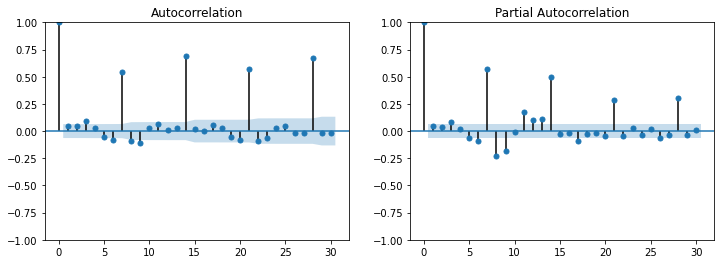

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
l=smt.graphics.plot_acf(y['Sales'], ax = ax[0])
l=smt.graphics.plot_pacf(y['Sales'], ax=ax[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  


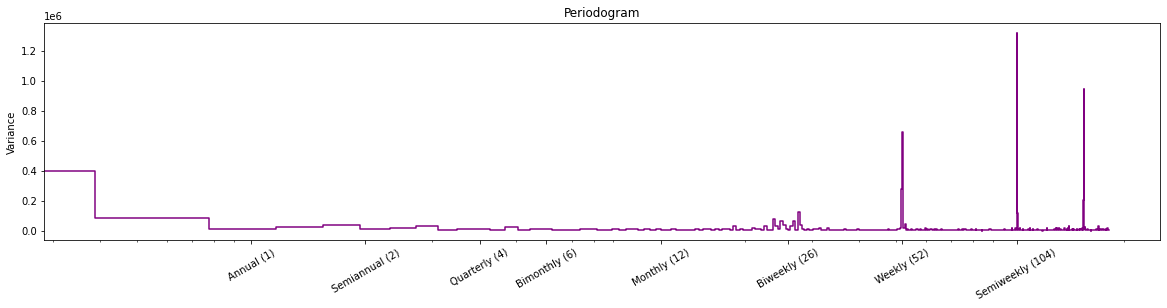

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20,4))
plot_periodogram(y['Sales'],'linear', ax)

## Sales of store

In [ ]:
print('Mean of train sales :',np.mean(y_train['Sales']))
print('Mean of test sales :',np.mean(y_test['Sales']))

Mean of train sales : 4669.9976470588235
Mean of test sales : 3863.108695652174


## Modling by ARIMA

In [ ]:

# # train = train_stores[store_num]
# # test = test_stores[store_num]

model = ARIMA(y_train['Sales'], order=(7, 0, 7),)
forecast, test_resid, model = train_arima(y_train, y_test, model)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Time taken = 5.529083967208862


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
print('ARIMA model with order = (7, 0, 7) ==> ARMA(7, 7)')
forecast.index = y_test.index
evaluate(y_train['Sales'], model.predict(), y_test['Sales'], forecast)

ARIMA model with order = (7, 0, 7) ==> ARMA(7, 7)
>>>>>>>> Evaluation metrics for Train <<<<<<<<
Root mean squared error  = 1661.83
Mean absolute error = 1125.43
Mean of residual = 0.68
Correlation = 0.77

>>>>>>>> Evaluation metrics for Test <<<<<<<<<
Root mean squared error = 1661.38
Mean absolute error = 1314.36
Mean of test residual = -792.64
Correlation = 0.74


In [ ]:
# plot_info_model(y_train['Sales'], model.predict(), y_test['Sales'], forecast, store_num, )
# y_train.head()

In [ ]:
# len(model.predict())

- Note: In 14-5-2015 and 4-6-2015 there was a state holiday

# Hybrid models

## Store that has stationarity

### ARIMA with Decision tree

In [ ]:
# model.forcast(len(train))
# model2 = DecisionTreeRegressor()
# model2.fit(store_data_train_x,( train - model.predict() ) )
# pred += model2.predict(store_data_test_x)
# resid = store_data_test_y - pred 

x, y = pre_process_store(df_train, store_num, future_days)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_until)

hy_model = BoostedHybrid(ARIMA(y_train['Sales'], order=(7,0,7)), DecisionTreeRegressor(), future_days)

hy_model.fit(x_train, y_train)

forecast = hy_model.predict(x_test, len(y_test))

test_resid = y_test - forecast 
train_resid = hy_model.y_train_resid
y_pred = hy_model.y_train_pred

# store_data_test_x

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  sort=sort,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/

Time taken = 0.09116876522699992 min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


#### Evaluation 

In [ ]:
print('ARIMA model with order = (7, 0, 7) ==> ARMA(7, 7) boosted with Decision tree')
forecast.index = y_test.index
evaluate(y_train, y_pred, y_test, forecast)

ARIMA model with order = (7, 0, 7) ==> ARMA(7, 7) boosted with Decision tree
>>>>>>>> Evaluation metrics for Train <<<<<<<<
Root mean squared error  = 0.00
Mean absolute error = 0.00
Mean of residual = 0.00
Correlation = 1.00

>>>>>>>> Evaluation metrics for Test <<<<<<<<<
Root mean squared error = 1794.59
Mean absolute error = 1315.89
Mean of test residual = -581.30
Correlation = 0.67


#### Plots 

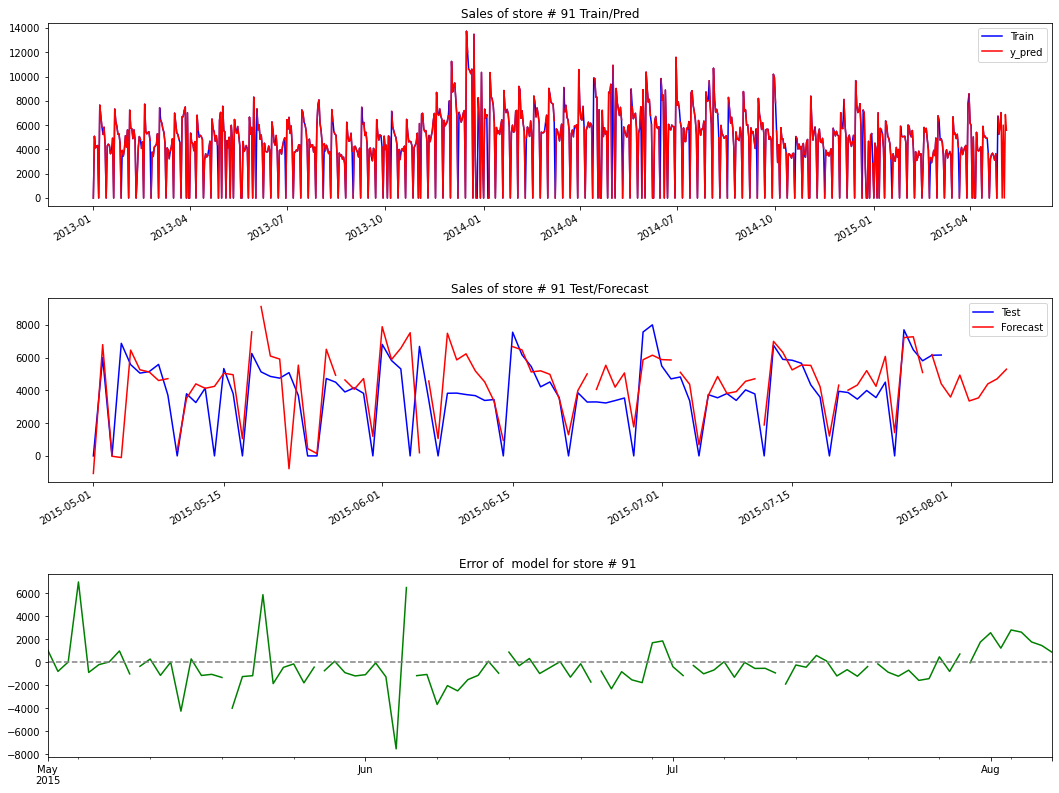

In [ ]:
plot_info_model(y_train, y_pred, y_test, forecast,store_num, every=len(y_train.columns))

#### Autocorrelatioon For residuals 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/p

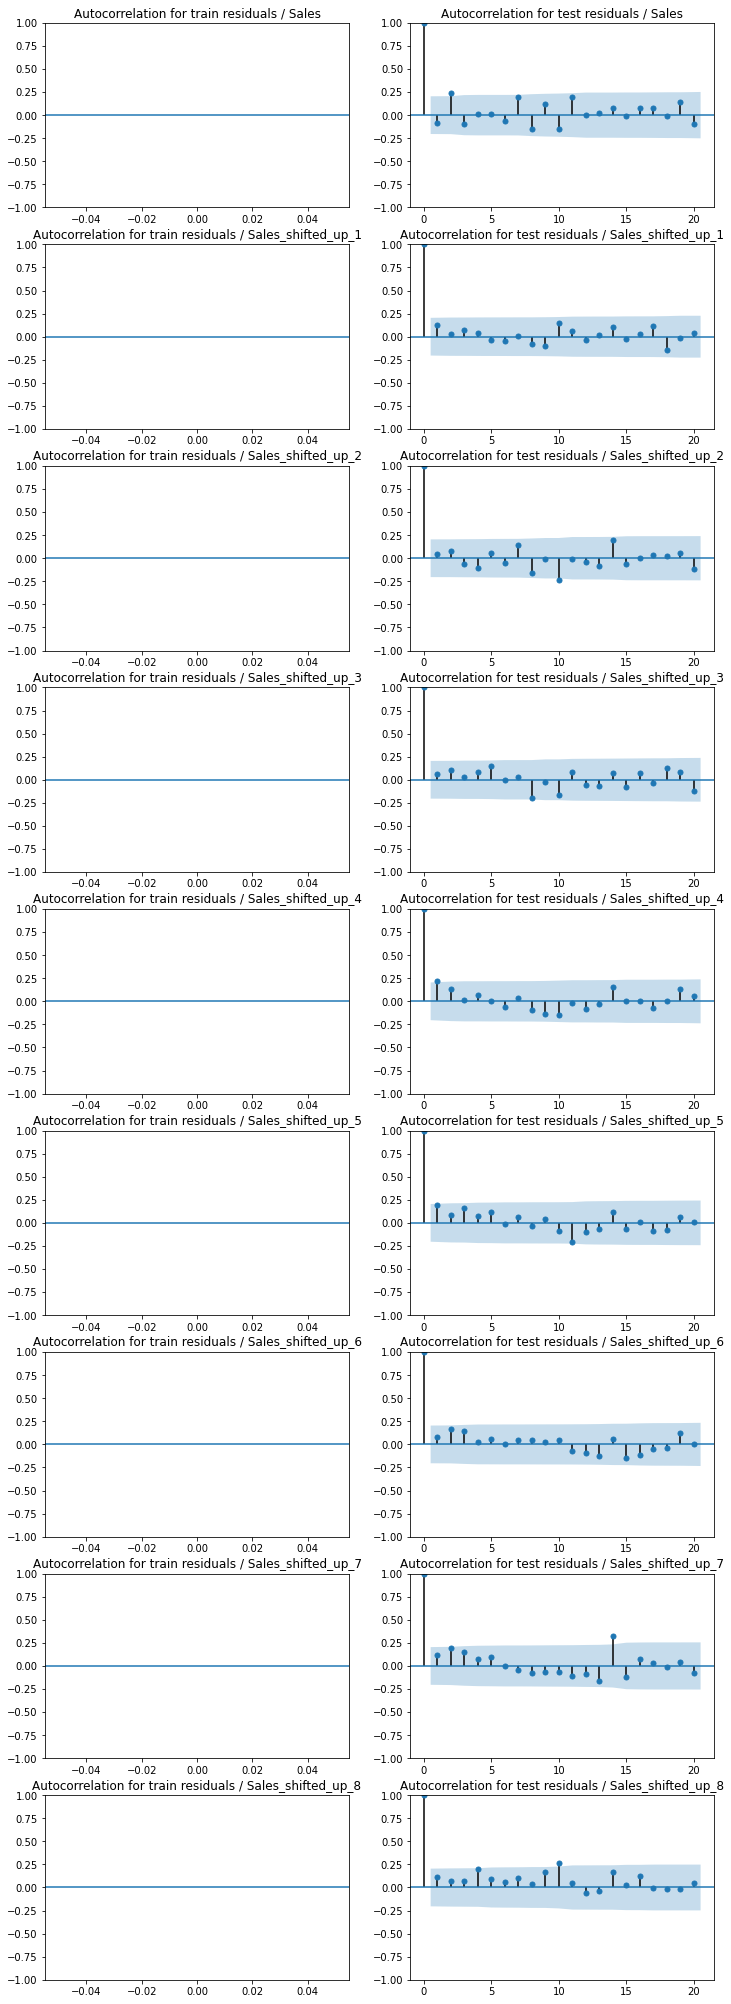

In [ ]:
plot_autocorr_resid(y_train, y_pred, y_test, forecast,)

### ARIMA model with K-neighbors

In [ ]:
store_num = store_have_stationarity[0]
x, y = pre_process_store(df_train, store_num, future_days)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_until)



for i in [i for i in range(1,10,2)]:
  hy_model = BoostedHybrid(ARIMA(y_train['Sales'], order=(7,0,7)), KNeighborsRegressor(n_neighbors=i), future_days)

  hy_model.fit(x_train, y_train)

  forecast = hy_model.predict(x_test, len(y_test))

  test_resid = y_test - forecast 
  train_resid = hy_model.y_train_resid
  y_pred = hy_model.y_train_pred
  print(f'ARIMA model with order = (7, 0, 7) ==> ARMA(7, 7) With KNN k = {i}')
  forecast.index = y_test.index
  evaluate(y_train, y_pred, y_test, forecast)
# store_data_test_x

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  sort=sort,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/

Time taken = 0.09135447343190511 min
ARIMA model with order = (7, 0, 7) ==> ARMA(7, 7) With KNN k = 1
>>>>>>>> Evaluation metrics for Train <<<<<<<<
Root mean squared error  = 0.00
Mean absolute error = 0.00
Mean of residual = 0.00
Correlation = 1.00

>>>>>>>> Evaluation metrics for Test <<<<<<<<<
Root mean squared error = 1739.94
Mean absolute error = 1244.21
Mean of test residual = -523.65
Correlation = 0.67


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

Time taken = 0.08977287610371908 min
ARIMA model with order = (7, 0, 7) ==> ARMA(7, 7) With KNN k = 3
>>>>>>>> Evaluation metrics for Train <<<<<<<<
Root mean squared error  = 1137.56
Mean absolute error = 738.65
Mean of residual = -13.09
Correlation = 0.90

>>>>>>>> Evaluation metrics for Test <<<<<<<<<
Root mean squared error = 1466.21
Mean absolute error = 1127.55
Mean of test residual = -568.30
Correlation = 0.77


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

Time taken = 0.09123737414677938 min
ARIMA model with order = (7, 0, 7) ==> ARMA(7, 7) With KNN k = 5
>>>>>>>> Evaluation metrics for Train <<<<<<<<
Root mean squared error  = 1274.91
Mean absolute error = 821.69
Mean of residual = -14.32
Correlation = 0.87

>>>>>>>> Evaluation metrics for Test <<<<<<<<<
Root mean squared error = 1450.17
Mean absolute error = 1119.25
Mean of test residual = -596.60
Correlation = 0.78


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

Time taken = 0.09050639073053995 min
ARIMA model with order = (7, 0, 7) ==> ARMA(7, 7) With KNN k = 7
>>>>>>>> Evaluation metrics for Train <<<<<<<<
Root mean squared error  = 1334.00
Mean absolute error = 850.17
Mean of residual = -8.46
Correlation = 0.86

>>>>>>>> Evaluation metrics for Test <<<<<<<<<
Root mean squared error = 1456.19
Mean absolute error = 1117.37
Mean of test residual = -593.66
Correlation = 0.78


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

Time taken = 0.08898486693700154 min
ARIMA model with order = (7, 0, 7) ==> ARMA(7, 7) With KNN k = 9
>>>>>>>> Evaluation metrics for Train <<<<<<<<
Root mean squared error  = 1369.34
Mean absolute error = 868.13
Mean of residual = -10.47
Correlation = 0.85

>>>>>>>> Evaluation metrics for Test <<<<<<<<<
Root mean squared error = 1463.07
Mean absolute error = 1111.84
Mean of test residual = -607.21
Correlation = 0.78


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


#### Evaluation 

In [ ]:
print('ARIMA model with order = (7, 0, 7) ==> ARMA(7, 7)')
forecast.index = y_test.index
evaluate(y_train, y_pred, y_test, forecast)

ARIMA model with order = (7, 0, 7) ==> ARMA(7, 7)
>>>>>>>> Evaluation metrics for Train <<<<<<<<
Root mean squared error  = 1137.56
Mean absolute error = 738.65
Mean of residual = -13.09
Correlation = 0.90

>>>>>>>> Evaluation metrics for Test <<<<<<<<<
Root mean squared error = 1466.21
Mean absolute error = 1127.55
Mean of test residual = -568.30
Correlation = 0.77


#### Plots

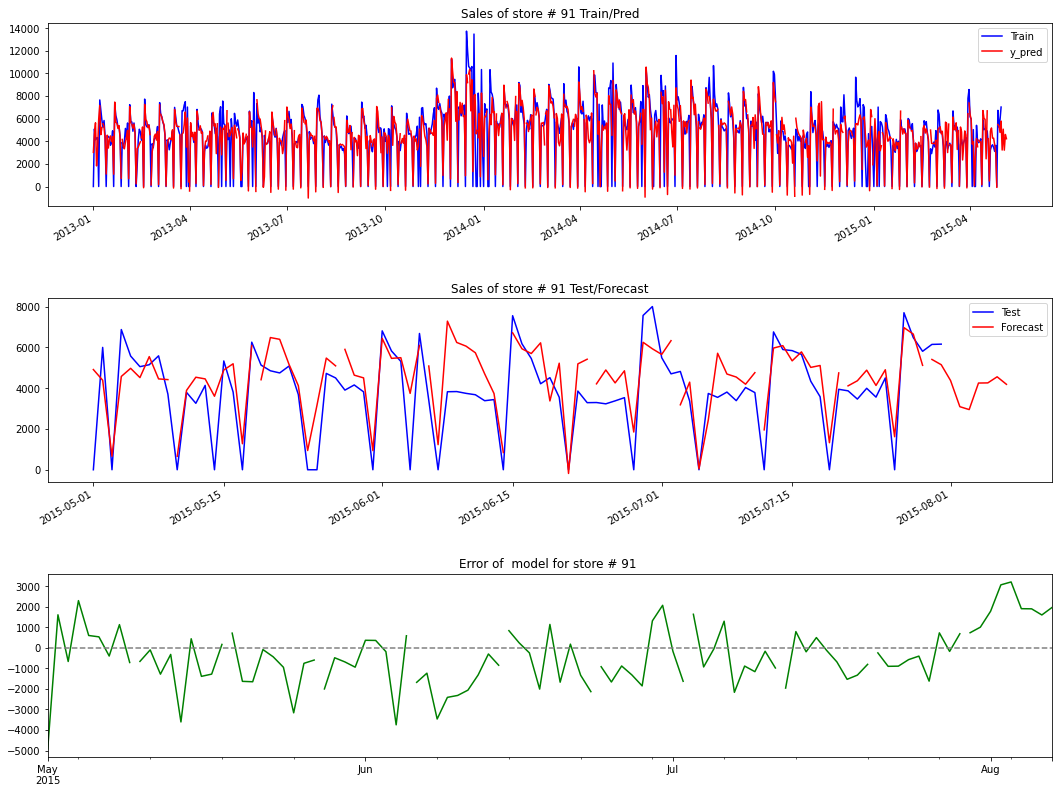

In [ ]:
plot_info_model(y_train, y_pred, y_test, forecast, store_num, every=len(y_train.columns))

#### Autocorrelation for residuals

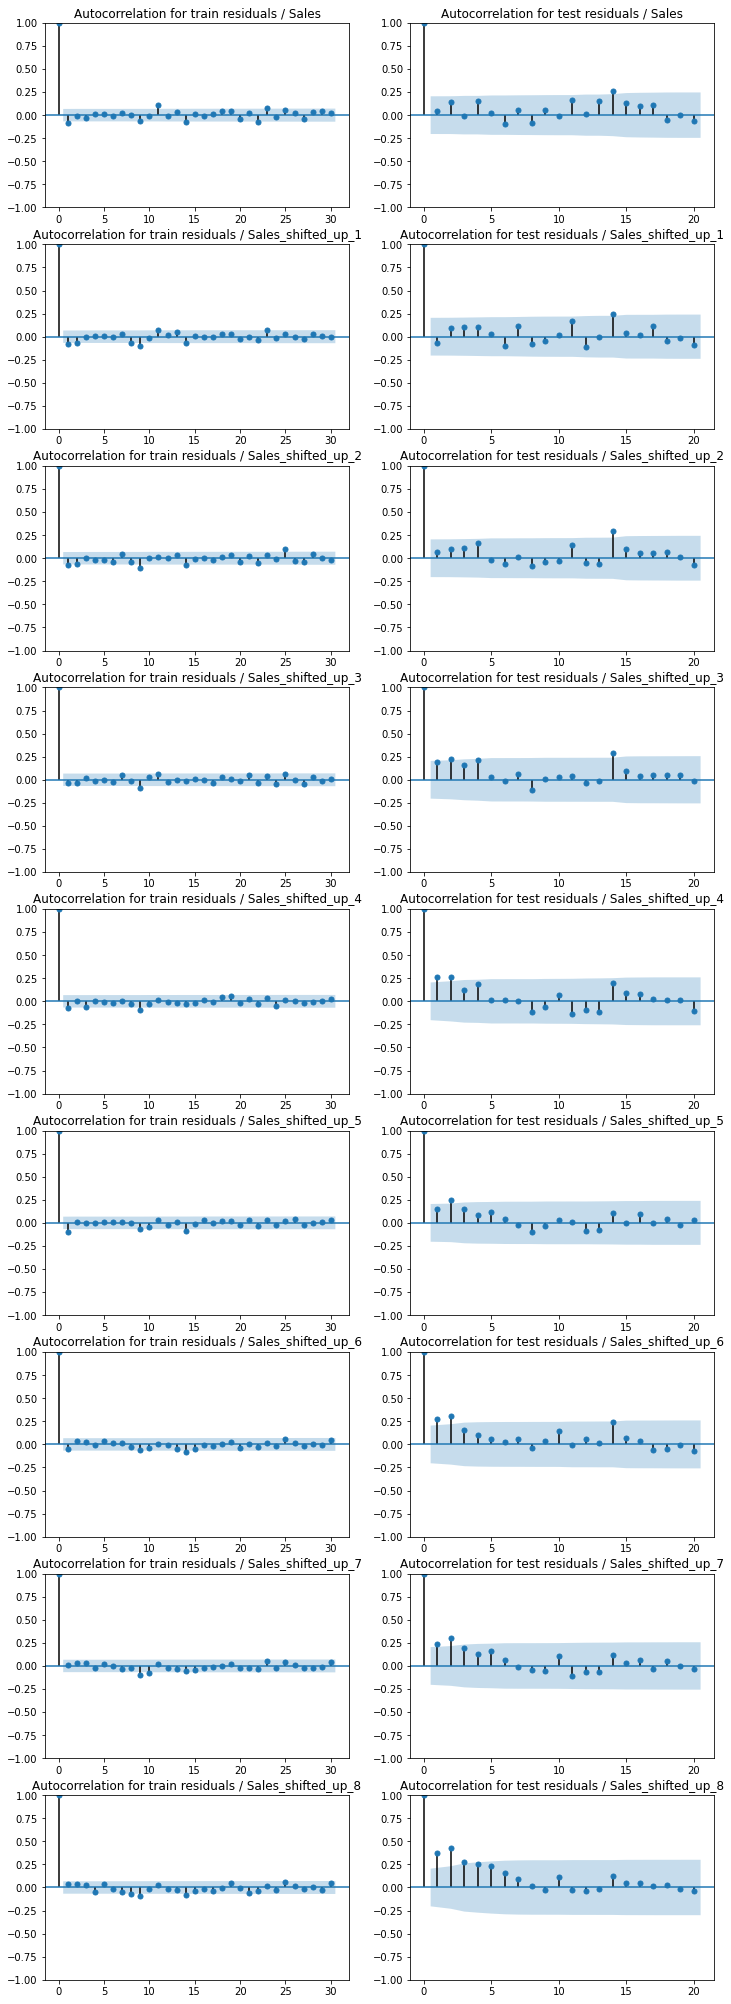

In [ ]:
plot_autocorr_resid(y_train, y_pred, y_test, forecast)

In [ ]:
# plot_info_model(y_train, y_test, y_pred, forecast, test_resid, store_num)

### ARIMA model with linearRegression 

In [ ]:
x, y = pre_process_store(df_train, store_num, future_days)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_until)

hy_model = BoostedHybrid(ARIMA(y_train['Sales'], order=(7,0,7)), LinearRegression(), future_days)

hy_model.fit(x_train, y_train)

forecast = hy_model.predict(x_test, len(y_test))

test_resid = y_test - forecast 
train_resid = hy_model.y_train_resid
y_pred = hy_model.y_train_pred


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  sort=sort,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/

Time taken = 0.07848215897878011 min


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


#### Evaluation 

In [ ]:
print('ARIMA model with order = (7, 0, 7) boosted with LinearRegression')
forecast.index = y_test.index
evaluate(y_train, y_pred, y_test, forecast)

ARIMA model with order = (7, 0, 7) boosted with LinearRegression
>>>>>>>> Evaluation metrics for Train <<<<<<<<
Root mean squared error  = 1434.70
Mean absolute error = 950.71
Mean of residual = 0.00
Correlation = 0.84

>>>>>>>> Evaluation metrics for Test <<<<<<<<<
Root mean squared error = 1469.06
Mean absolute error = 1171.73
Mean of test residual = -772.11
Correlation = 0.81


#### Plots 

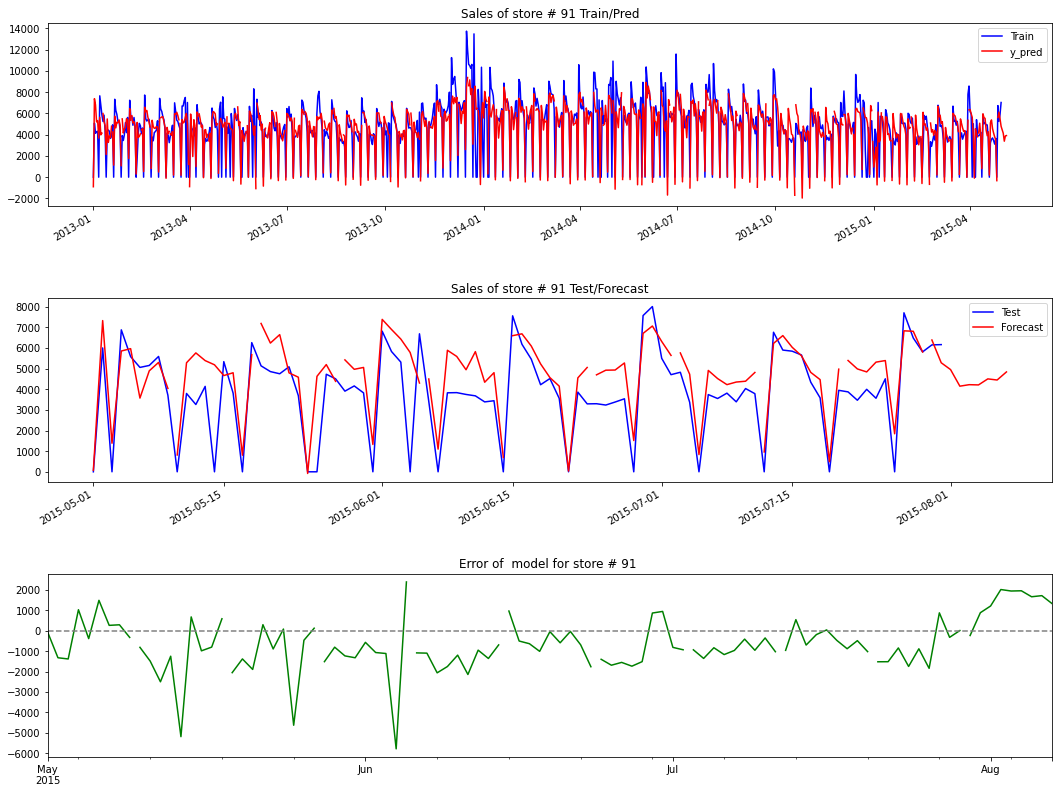

In [ ]:
plot_info_model(y_train, hy_model.y_train_pred, y_test, forecast, store_num, len(y_train.columns))

#### Autocorrelation For residuals 

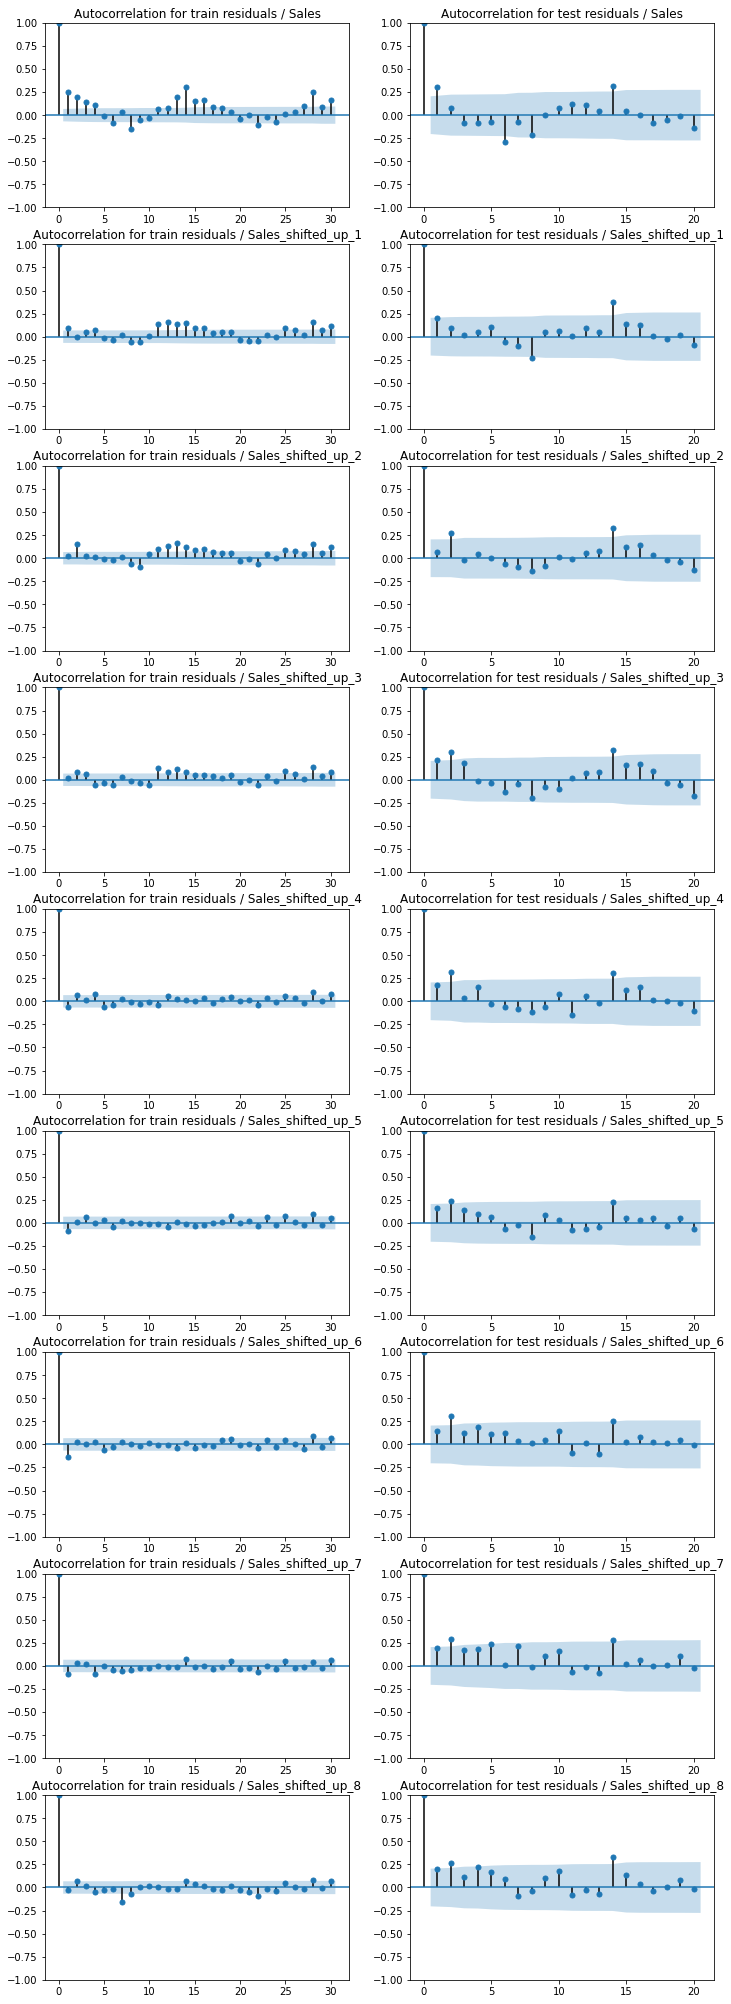

In [ ]:
plot_autocorr_resid(y_train, hy_model.y_train_pred, y_test, forecast)

In [ ]:
# model3 = LinearRegression()

# model3.fit(store_data_train_x,( train - model.predict() ) )

# pred += model3.predict(store_data_test_x)
# resid = store_data_test_y - pred 

# plot_info_model(train, test, pred, resid, store_num)

## Store that does not have stationarity

In [ ]:
store_num = store_not_have_stationarity[1]

x, y = pre_process_store(df_train, store_num, future_days)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_until)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  sort=sort,


### SARIMAX

In [ ]:
model = SARIMAX(y_train['Sales'], order=(14,1,14), seasonal_order=(3,0,3,52))
forecast, test_resid, model = train_arima(y_train, y_test, model)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Time taken = 2057.4831070899963


#### Evaluation 

In [ ]:
print('Mean of train sales :',np.mean(y_train['Sales']))
print('Mean of test sales :',np.mean(y_test['Sales']))

Mean of train sales : 4119.715294117647
Mean of test sales : 4153.260869565217


In [ ]:
forecast.index = y_test.index
evaluate(y_train['Sales'], model.predict(), y_test['Sales'], forecast)

>>>>>>>> Evaluation metrics for Train <<<<<<<<
Root mean squared error  = 1320.39
Mean absolute error = 862.74
Mean of residual = 136.90
Correlation = 0.83

>>>>>>>> Evaluation metrics for Test <<<<<<<<<
Root mean squared error = 2023.21
Mean absolute error = 1604.80
Mean of test residual = 57.64
Correlation = 0.57


#### Plots 

In [ ]:
# plot_info_model(y_train, hy_model.y_train_pred, y_test, forecast, store_num ,len(y_train.columns))

#### Autocorrelation for residuals

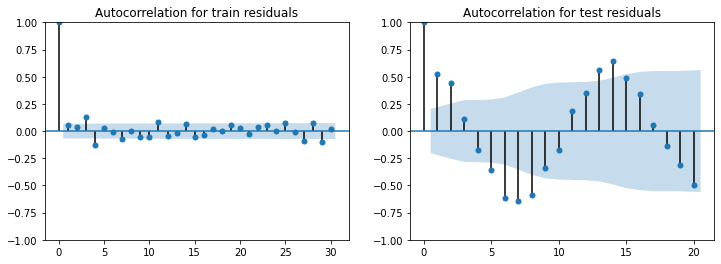

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
train_resid = y_train['Sales'] -  model.predict()
test_resid = y_test['Sales'] - forecast
l=smt.graphics.plot_acf(train_resid, ax=ax[0], title='Autocorrelation for train residuals')
l=smt.graphics.plot_acf(test_resid, ax=ax[1], title='Autocorrelation for test residuals')

### SARIMAX of order=(7, 1, 7), seasonal_order=(3, 0, 3, 52) with LinearRegression

In [ ]:
hy_model = BoostedHybrid(SARIMAX(y_train['Sales'], order=(7, 1, 7), seasonal_order=(3, 0, 3, 52)), LinearRegression(), future_days)

hy_model.fit(x_train, y_train)

forecast = hy_model.predict(x_test, len(y_test))

test_resid = y_test - forecast 
train_resid = hy_model.y_train_resid
y_pred = hy_model.y_train_pred


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Time taken = 18.79505426088969 min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


#### Evaluation 

In [ ]:
forecast.index = y_test.index
evaluate(y_train, y_pred, y_test, forecast)

>>>>>>>> Evaluation metrics for Train <<<<<<<<
Root mean squared error  = 1153.70
Mean absolute error = 749.41
Mean of residual = 0.00
Correlation = 0.87

>>>>>>>> Evaluation metrics for Test <<<<<<<<<
Root mean squared error = 1299.43
Mean absolute error = 922.04
Mean of test residual = 136.98
Correlation = 0.82


#### Plots 

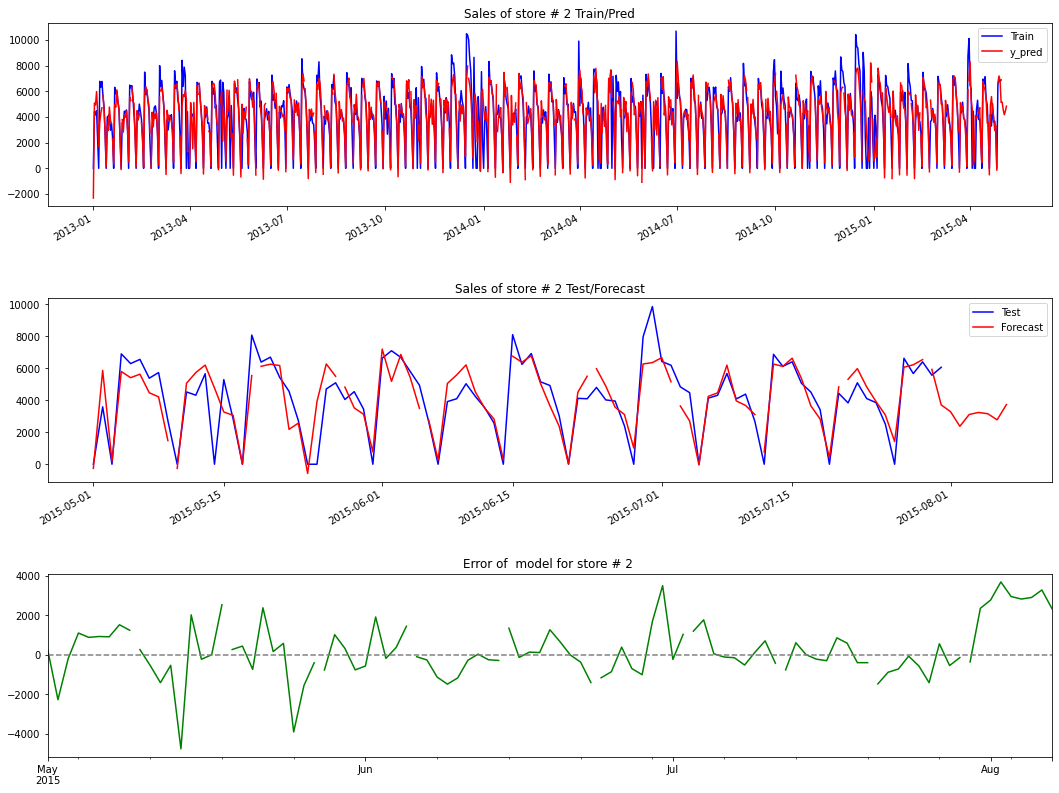

In [ ]:
plot_info_model(y_train, hy_model.y_train_pred, y_test, forecast, store_num ,len(y_train.columns))

#### Autocorrelation for residuals

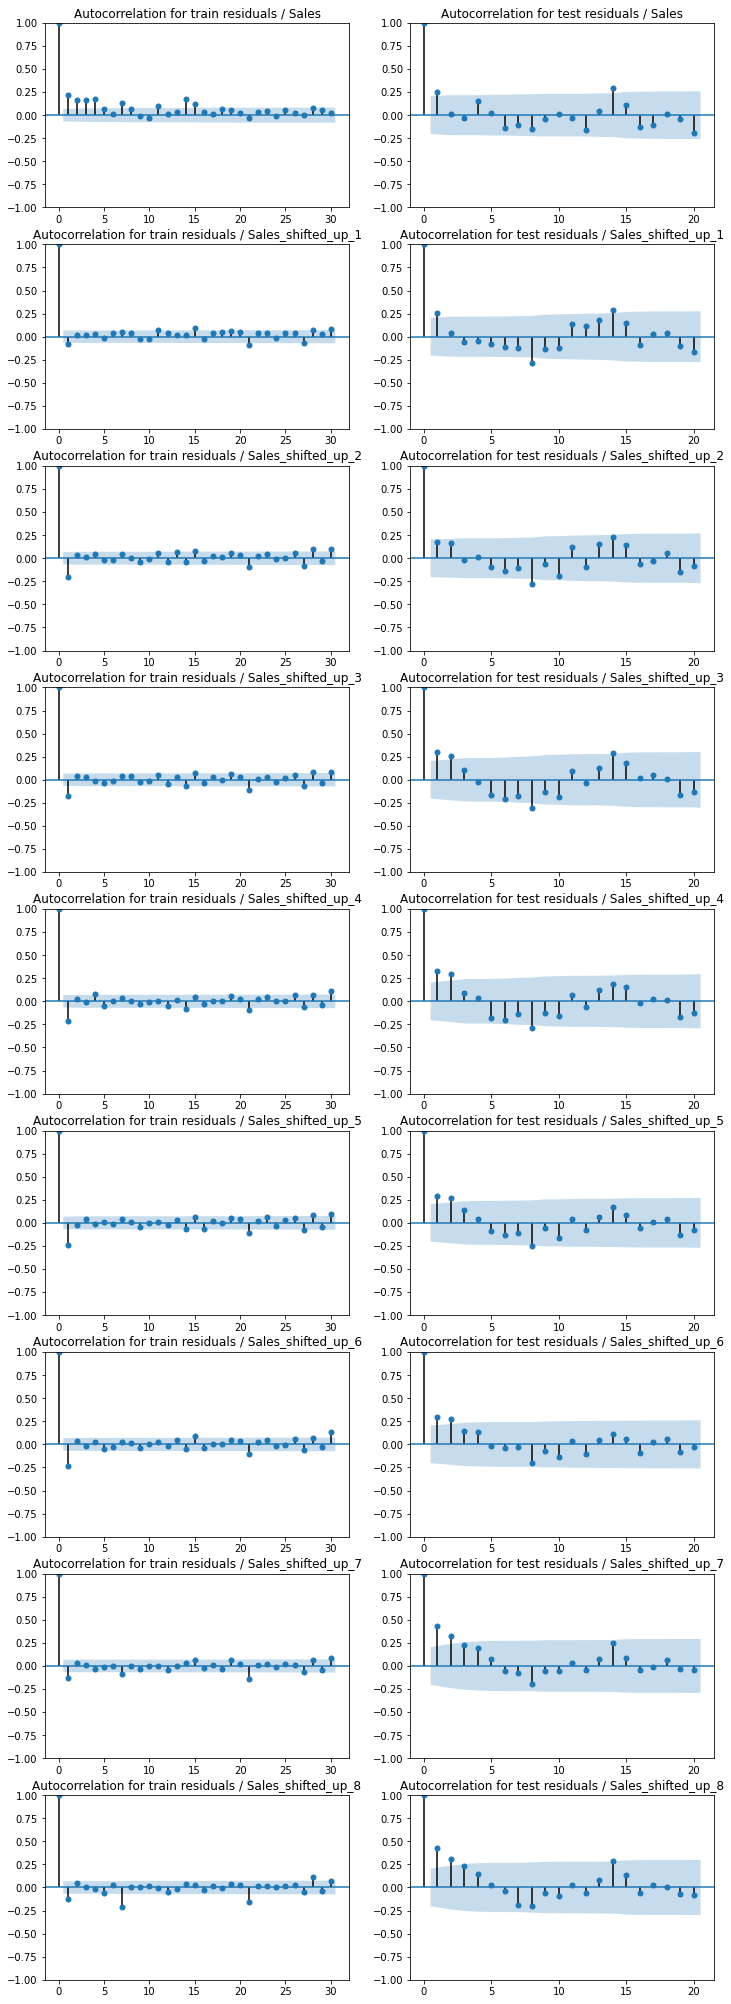

In [ ]:
plot_autocorr_resid(y_train, hy_model.y_train_pred, y_test, forecast)

### SARIMAX order=(7, 1, 7), seasonal_order=(3, 0, 3, 52) model with Decision tree 

In [ ]:

hy_model = BoostedHybrid(SARIMAX(y_train['Sales'], order=(7, 1, 7), seasonal_order=(3, 0, 3, 52)), DecisionTreeRegressor(), future_days)

hy_model.fit(x_train, y_train)

forecast = hy_model.predict(x_test, len(y_test))

test_resid = y_test - forecast 
train_resid = hy_model.y_train_resid
y_pred = hy_model.y_train_pred


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tup

Time taken = 18.672849595546722 min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


#### Evaluation 

In [ ]:
forecast.index = y_test.index
evaluate(y_train, y_pred, y_test, forecast)

>>>>>>>> Evaluation metrics for Train <<<<<<<<
Root mean squared error  = 0.00
Mean absolute error = 0.00
Mean of residual = 0.00
Correlation = 1.00

>>>>>>>> Evaluation metrics for Test <<<<<<<<<
Root mean squared error = 1600.99
Mean absolute error = 1137.95
Mean of test residual = 101.43
Correlation = 0.76


#### Plots 

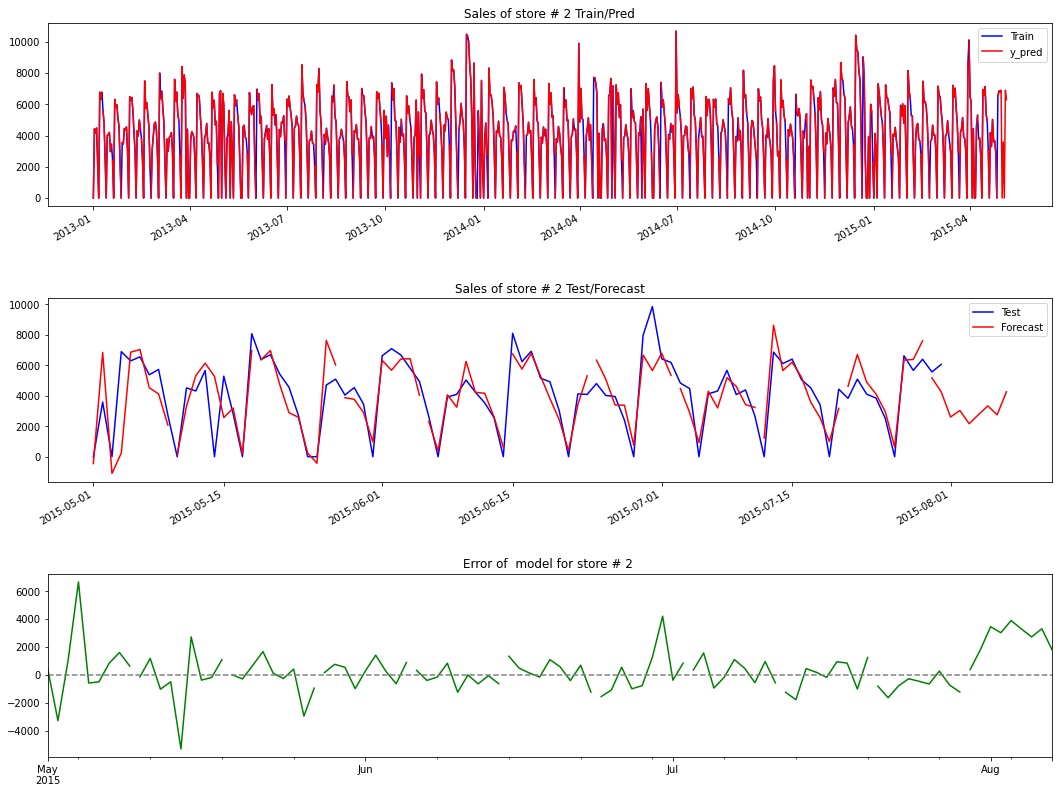

In [ ]:
plot_info_model(y_train, hy_model.y_train_pred, y_test, forecast, store_num ,len(y_train.columns))

#### Autocorrelation for residuals

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/p

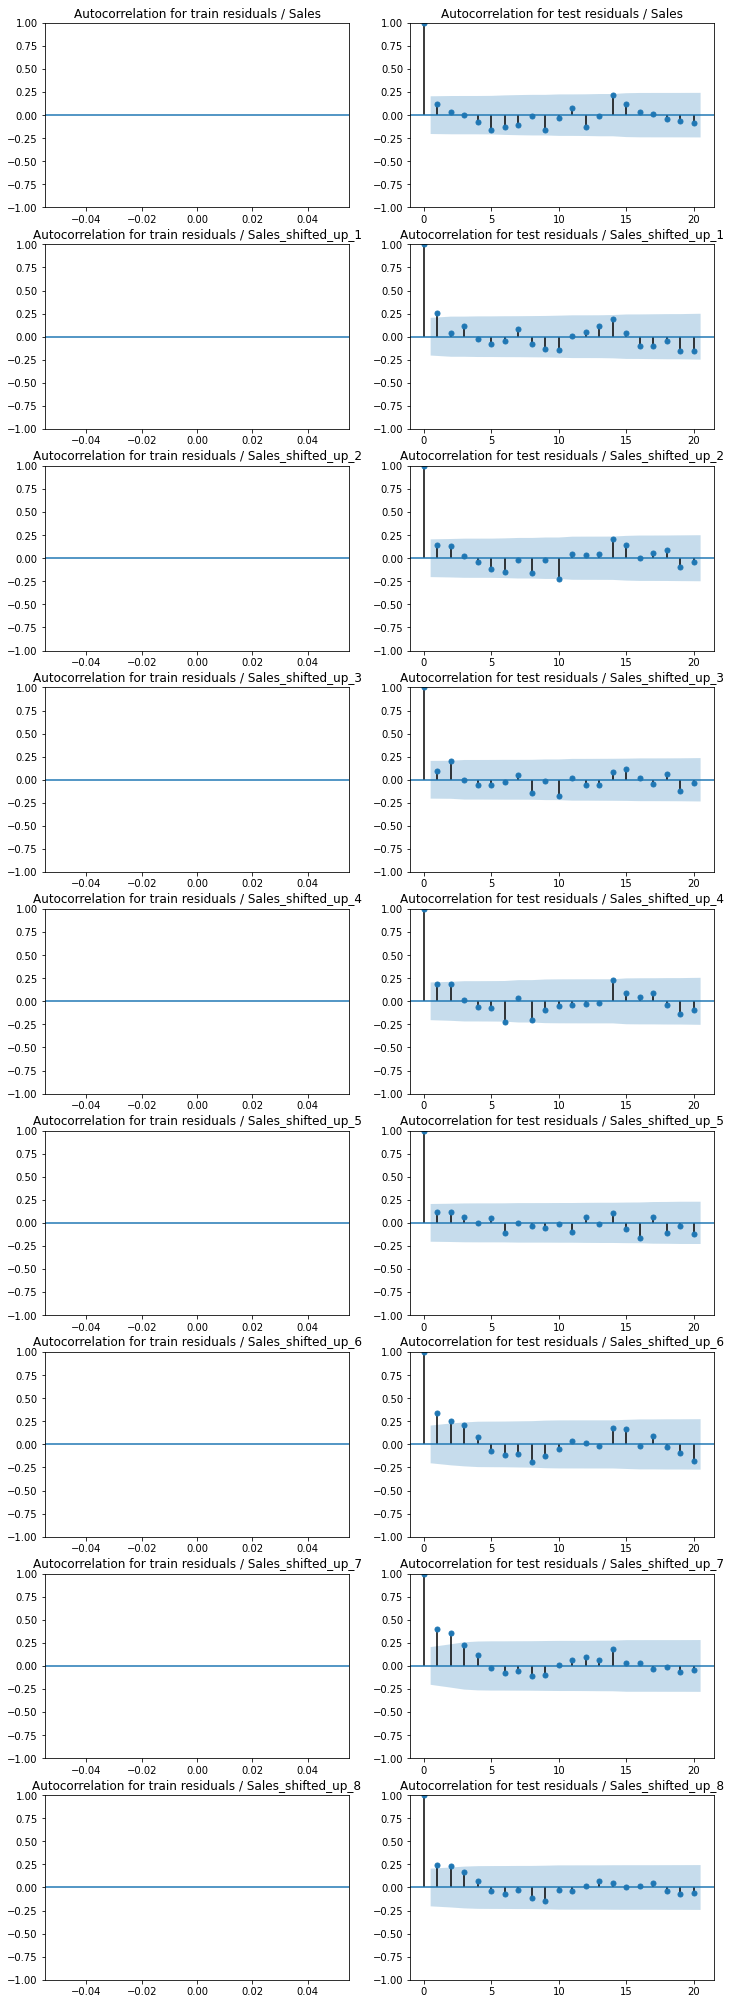

In [ ]:
plot_autocorr_resid(y_train, hy_model.y_train_pred, y_test, forecast)

### SARIMAX order=(7, 1, 7), seasonal_order=(3, 0, 3, 52)model with LinearRegression modeel 

In [ ]:

hy_model = BoostedHybrid(SARIMAX(y_train['Sales'], order=(7, 1, 7), seasonal_order=(3, 0, 3, 52)), RegressorChain(LinearRegression()), future_days)

hy_model.fit(x_train, y_train)

forecast = hy_model.predict(x_test, len(y_test))

test_resid = y_test - forecast 
train_resid = hy_model.y_train_resid
y_pred = hy_model.y_train_pred


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tup

Time taken = 21.878929058710735 min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


#### Evaluation 

In [ ]:
forecast.index = y_test.index
evaluate(y_train, y_pred, y_test, forecast)

>>>>>>>> Evaluation metrics for Train <<<<<<<<
Root mean squared error  = 1443.56
Mean absolute error = 944.11
Mean of residual = -0.00
Correlation = 0.83

>>>>>>>> Evaluation metrics for Test <<<<<<<<<
Root mean squared error = 1486.12
Mean absolute error = 1066.39
Mean of test residual = 223.73
Correlation = 0.72


#### Plots 

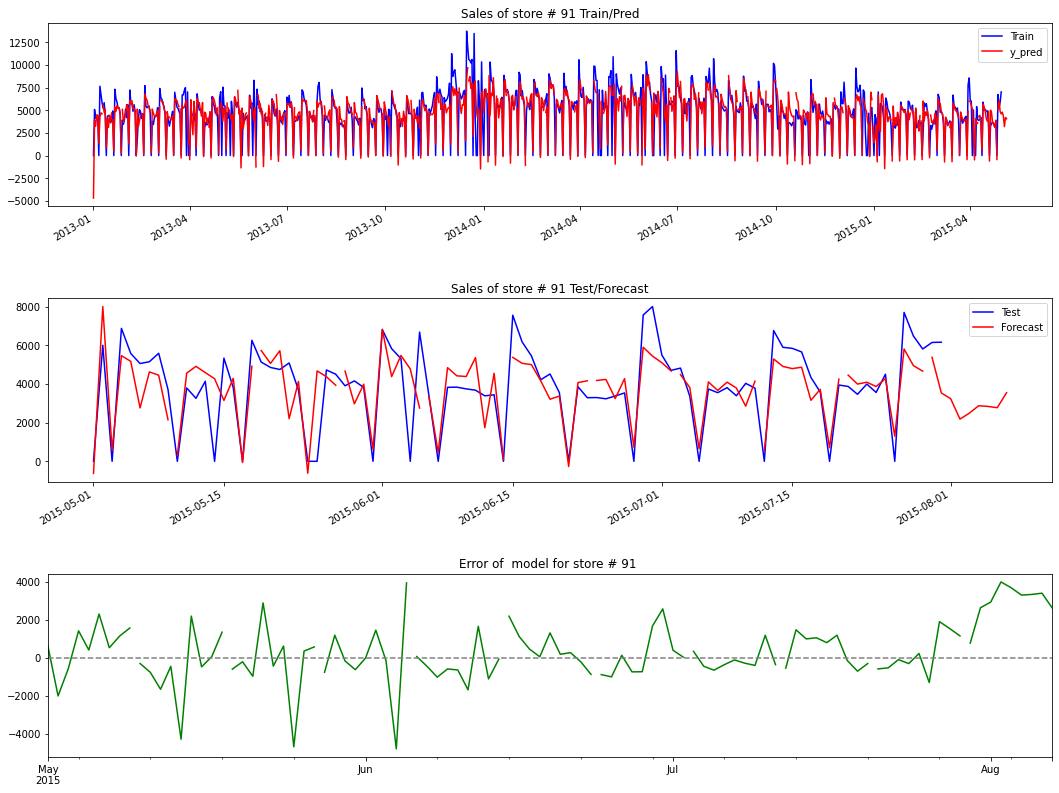

In [ ]:
plot_info_model(y_train, hy_model.y_train_pred, y_test, forecast, store_num ,len(y_train.columns))

#### Autocorrelation for residuals

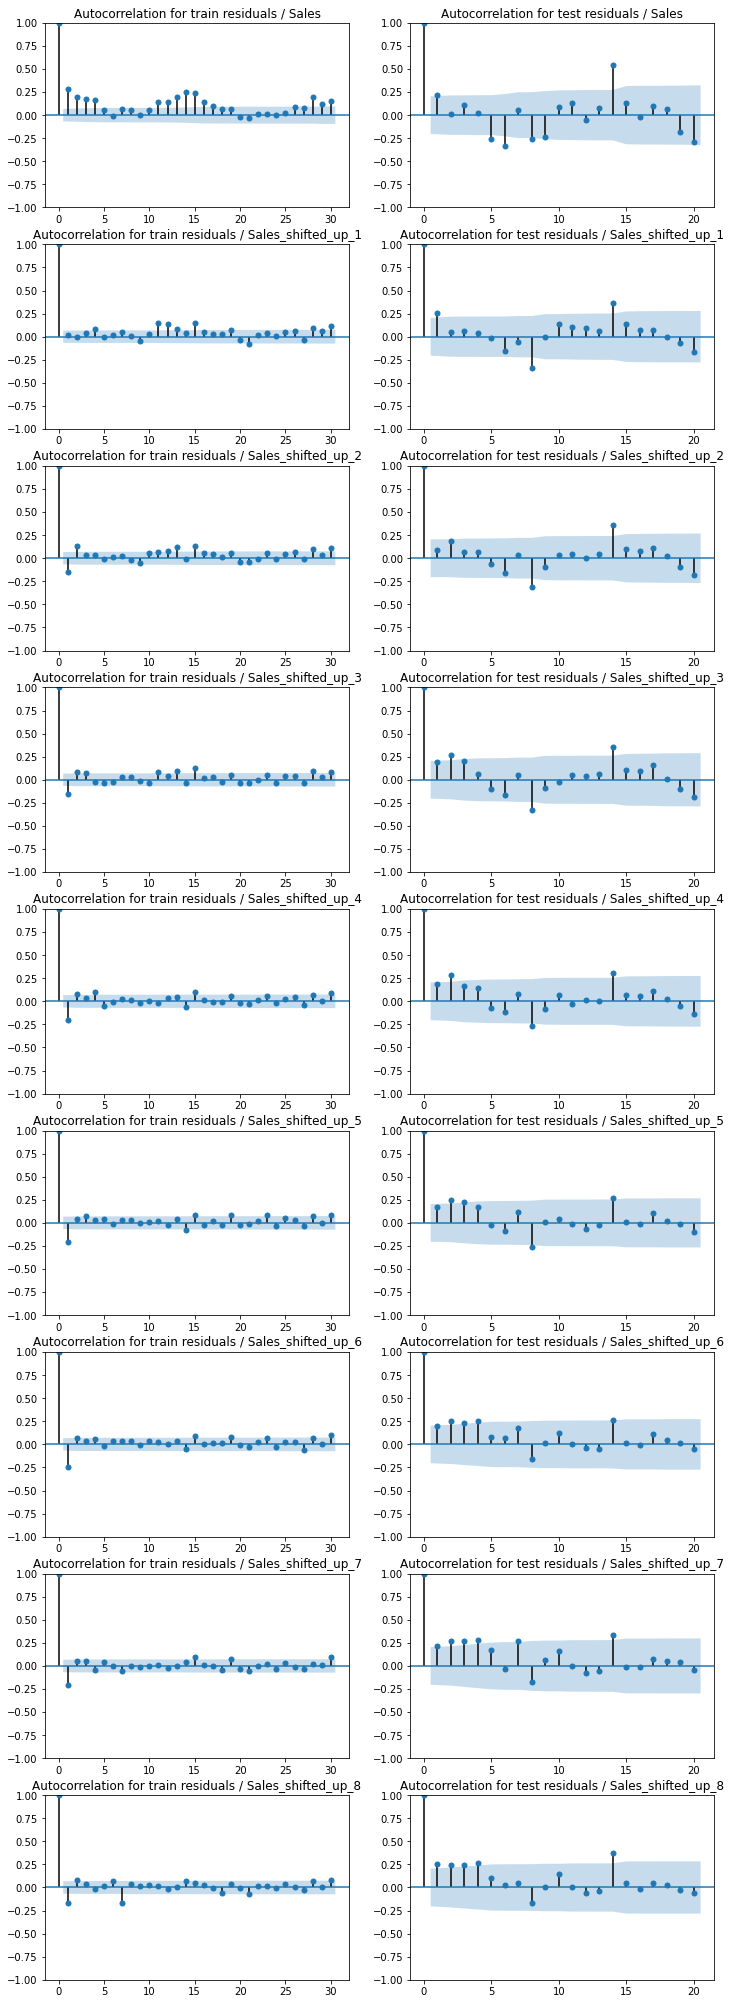

In [ ]:
plot_autocorr_resid(y_train, hy_model.y_train_pred, y_test, forecast)

## Brief of Modling

Mean of train sales : 4119.715294117647

Mean of test sales : 4153.260869565217

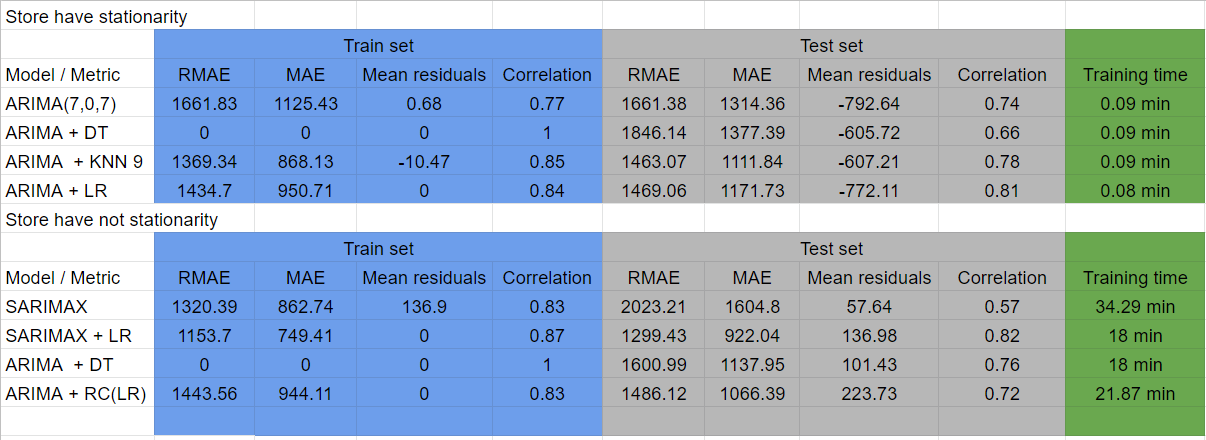